In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# I. Monte-Carlo sampling of some multiplicative free convolutions.

Let $\mu_P$ be the limiting spectral measure of a population matrix $\Sigma$, 
and $\mu_{MP}$ is the Marchenko-Pastur distribution.
$$ \mu_{MP} = \frac{1}{2 \pi} \frac{\sqrt{(x-l)(r-x)}}{x} dx ,$$
where 
$$r = (1+\sqrt{c})^2$$
$$l = (1-\sqrt{c})^2$$
and $c$ being the scale parameter.


Consider a Wishart matrix $W$ of size $(p,N)$, with $N \rightarrow \infty$, $p/N \rightarrow \infty$. 
By FPT, the limiting empirical spectral distribution of
$$ \Sigma^{\frac{1}{2}} W \Sigma^{\frac{1}{2}}$$
is the free convolution:
$$ \nu := \mu_P \boxtimes \mu_{MP}$$

Here we sample empirical versions of $\nu$ for three cases:
1. White case ($\mu_P = \delta_1$) obtained with $ \Sigma = Id_p $.
2. Three diracs for $\mu_P$.
3. Toeplitz with coefficients $\left( 0.3^{|i-j|} \ ; \ 0 \leq i,j \leq p \right)$




In [2]:
N=500
num_bins=20

Scenario = "Case2"  
measures = "all"   #"point" or  "all" 


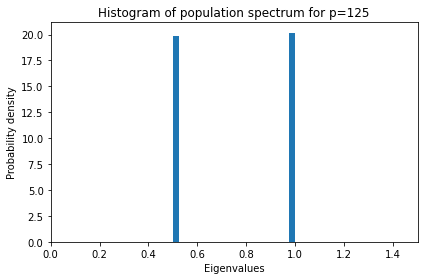

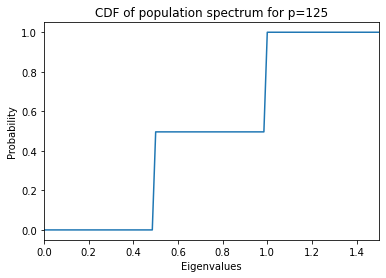

In [3]:
# Create population spectrum
if Scenario=="Case1":
    c = 0.4
    p = int(c*N)
    r = (1+np.sqrt(c))**2 #Right end of MP
    l = (1-np.sqrt(c))**2 #Left end of MP
    population_spectrum = np.ones( p )
elif Scenario=="Case2":
    c = 0.25
    p = int(c*N)
    weights = np.array( [1, 1] )
    weights = weights/np.sum( weights )
    support = np.array( [0.5, 1] )

    population_cdf = np.cumsum( weights )

    population_spectrum = np.zeros( (p,) )
    block_begin = 0
    for i in range( len(weights) ):
        block_end = int( population_cdf[i]*p )
        population_spectrum[block_begin:block_end] = support[i]
        block_begin = block_end

elif Scenario=="Case3":
    c = 0.2
    p = int(c*N)
    indices = np.arange( 0, p, 1)
    toeplitz_row    = 0.3**indices
    toeplitz = scipy.linalg.toeplitz( toeplitz_row)
    
    population_spectrum, U = np.linalg.eig(toeplitz)
    population_spectrum = np.sort( population_spectrum )
else:
    print( "Please specify a scenario..." )

# Histogram of population spectrum
fig, ax = plt.subplots()
n, bins, patches = ax.hist(population_spectrum, num_bins, density=True)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of population spectrum for p={}'.format(p))
fig.tight_layout()
plt.xlim(0,np.max(population_spectrum)+0.5)
plt.show()

interval_max = np.max(population_spectrum)+0.5
interval       = np.linspace( 0, interval_max, 100)
population_cdf = np.zeros_like( interval )
for i in range( len(interval) ):
    t = interval[i]
    population_cdf[i] = np.count_nonzero( population_spectrum <= t )
population_cdf = population_cdf/p
plt.plot( interval, population_cdf )
plt.xlabel('Eigenvalues')
plt.ylabel('Probability')
plt.title(r'CDF of population spectrum for p={}'.format(p))
plt.xlim(0,np.max(population_spectrum)+0.5)
plt.show()

 Shape of Wishart:  (125, 125)


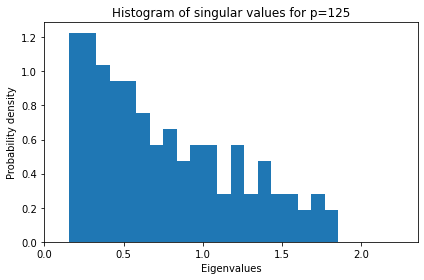

In [4]:
# Sample
G = np.random.normal( size=(p, N) )
G = np.dot( np.diag( np.sqrt(population_spectrum)) , G)
W = G.dot( G.T )
print(" Shape of Wishart: ", W.shape)
W = W/N
diag, U = np.linalg.eig(W)
diag = 1.0*np.sort( diag )

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
if Scenario=='Case1':
    y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins*c) # Added extra c. I believe this is the c part of the mass, while (1-c) is a Dirac at zero
    ax.plot(bins, y, '--', linewidth=4)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for p={}'.format(p))
fig.tight_layout()
plt.xlim(0,np.max(diag)+0.5)
plt.show()

# II. Dictionary build

## II. 1. Following El Karoui: Fix  $\nu_F(z_i)$ and compute $z_i$

Range of eigenvalues:  0.15752982741870047 1.8543151414375036


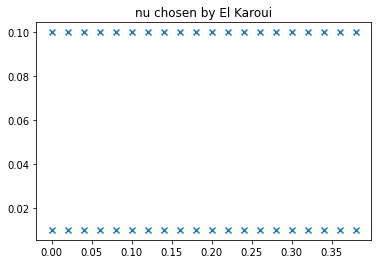

In [5]:
nu = np.array( [complex(0.02*a,b) for a in range(0, 20) for b in [0.01,0.1]] )
#nu = np.array( [complex(0.01*a,b) for a in range(-50, 50) for b in [0.01,0.1]] )

l1 = np.max( diag )
lp = np.min( diag )
print( "Range of eigenvalues: ", lp, l1)

plt.figure()
plt.scatter( np.real(nu), np.imag(nu), marker='x')
plt.title("nu chosen by El Karoui")
plt.show()

diag_norm = diag/l1

Building dictionary...


/home/mkammoun/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)



Checking that optimization worked...
Bad indices: [0.08+0.01j 0.38+0.01j]
Max error  : 0.31759883995998134

Removing bad indices...


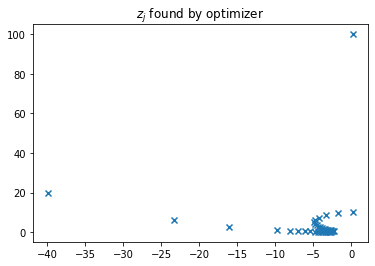

In [6]:
from freeDeconvolution import elkaroui, sampling

print( "Building dictionary...")
Z = elkaroui.build_dictionary( nu, c, diag)
print( "")

print( "Checking that optimization worked...")
nu_check = -(1-c)/Z + c*elkaroui.stieltjes(Z, diag)
nu_errors = np.abs(nu - nu_check)
bad_indices = np.where(nu_errors > 1e-5)
print( "Bad indices:", nu[bad_indices] )
print( "Max error  :", np.max(nu_errors) )
print( "" )

# Clean-up if necessary
if len(bad_indices):
    print("Removing bad indices...")
    Z  = np.delete( Z , bad_indices )
    nu = np.delete( nu, bad_indices)

plt.figure()
plt.scatter( np.real(Z), np.imag(Z), marker='x')
plt.title("$z_j$ found by optimizer")
plt.show()

dictionary = (Z, nu)

In [7]:
# Do a few checks in the first scenario
if Scenario=='Case1':
  errors = []
  c_interval = np.linspace( 0.1, 1.0, 100)
  for c_test in c_interval:
    error = np.linalg.norm(1/nu + Z - c_test*1/(1+nu))/len(Z)
    errors.append( error )
  errors = np.array( errors )

  plt.plot( c_interval, errors)
  plt.title("Errors as a function of c")
  plt.ylim( (0, np.max(errors)))
  plt.show()

  errors_l1  = []
  errors_l2  = []
  errors_max = []
  pos_interval = np.linspace( 0.1, 3, 100)
  for t in pos_interval:
    error_l1  = np.linalg.norm(1/nu + Z - c*t/(1+t*nu), ord=1)/len(Z)
    error_l2  = np.linalg.norm(1/nu + Z - c*t/(1+t*nu))/np.sqrt(len(Z))
    error_max = np.max(1/nu + Z - c*t/(1+t*nu))
    #
    errors_l1.append( error_l1 )
    errors_l2.append( error_l2 )
    errors_max.append( np.abs(error_max) )

  errors = np.array( errors )


  plt.plot( pos_interval, errors_l1, label='l1 error')
  plt.plot( pos_interval, errors_l2, label='l2 error')
  plt.plot( pos_interval, errors_max, label='$l^\infty$ error')
  plt.title("Errors as a function of Dirac position")
  plt.legend()
  plt.show()

  print( "Minimal errors: ")
  print( np.min(errors_l1) )
  print( np.min(errors_l2) )
  print( np.min(errors_max) )

## II.2. Fix $z_j$ and deduce $\nu(z_j)$

In [8]:
#Z = np.linspace(0.1, 3, 200) + (1e-6)*1.0j
#plt.scatter( np.real(Z), np.imag(Z), marker='x')
#plt.title("Z")
#plt.show()

#nu = c*elkaroui.stieltjes(Z, diag) - (1-c)*1/Z
#plt.figure()
#plt.scatter( np.real(nu), np.imag(nu), marker='x')
#plt.title("nu")
#plt.show()


In [9]:
#errors = []
#c_interval = np.linspace( 0.1, 3, 100)
#for c in c_interval:
#  error = np.linalg.norm(1/nu + Z - c*1/(1+nu))/len(Z)
#  errors.append( error )
#errors = np.array( errors )

#plt.plot( c_interval, errors)
#plt.title("Errors as a function of c")
#plt.ylim( (0, np.max(errors)))
#plt.show()


In [10]:
#errors = []
#pos_interval = np.linspace( 0.1, 3, 100)
#for t in pos_interval:
#  error = np.linalg.norm(1/nu + Z - (1/c)*t/(1+t*nu))/len(Z)
#  errors.append( error )
#errors = np.array( errors )

#plt.plot( pos_interval, errors)
#plt.title("Errors as a function of c")
#plt.ylim( (0, np.max(errors)))
#plt.show()

# III. Convex optimization

In [11]:
# Support is case by case
if Scenario=='Case1':
    T = np.arange(0, 2, 0.005)
elif Scenario=='Case2':
    T = np.arange(0, 2, 0.05)
elif Scenario=='Case3':
    T = np.arange(0, 2.5, 0.1)

population_cdf = np.zeros_like( T )
for i in range( len(T) ):
    t = T[i]
    population_cdf[i] = np.count_nonzero( population_spectrum <= t )
population_cdf = population_cdf/p

def deconvolution( norm_type,measures):
    # Perform optimization
    weights, objective_value = elkaroui.perform_cvx_optimization( dictionary, T, c, norm_type, verbose=False,measures=measures)
    # Plots
    print("Found objective value: ", objective_value)
    plt.figure()
    if measures=="point":
        weights=[weights,np.zeros(len(T)),np.zeros(len(T))]
    T1=[] 
    T1.append(T[0])
    cdf=[(weights[0])[0]]
    for i in range(len(T)-1):
          
            T1.append((T[i]+T[i+1])/2)
            linear_step= (((T[i+1]+T[i])/2)**2-T[i]**2)/(T[i+1]**2-T[i]**2)
            cdf.append(cdf[-1]+ ((weights[1])[i])/2 + (weights[2])[i]*linear_step )
            T1.append(T[i+1] -0.0000001)
            cdf.append(cdf[-1]+ ((weights[1])[i])/2 + ((weights[2])[i])*(1-linear_step))
            T1.append(T[i+1]) 
            cdf.append(cdf[-1]+ (weights[0])[i+1])

            
    plt.plot( T1, cdf, label='Reconstruction from convex optimization')
    plt.plot( T, population_cdf, label='Ground truth')
    plt.title("CDF of population matrix")
    plt.ylim( (-0.1,1.1) )
    plt.legend()
    plt.show()

## III. 1. $l^\infty$ norm

Building cvxpy program...
Solving the convex problem...
Found objective value:  3.4848766699456885e-07


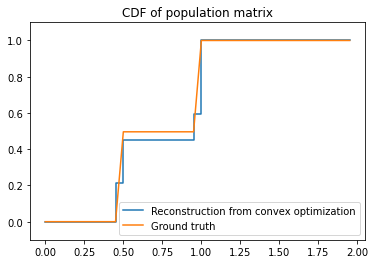

Building cvxpy program...
Solving the convex problem...
0.26719413179813967
Found objective value:  3.0261933329835026e-07


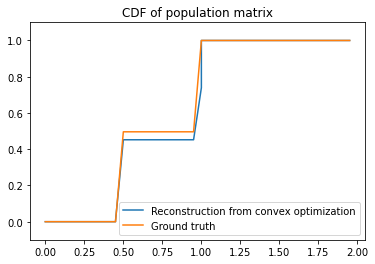

In [12]:
deconvolution('linfty','point')
deconvolution('linfty','all')

## III. 2. $l^1$ norm

Building cvxpy program...
Solving the convex problem...
Found objective value:  1.484926818099894e-07


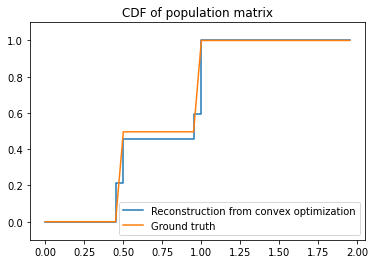

Building cvxpy program...
Solving the convex problem...
0.2879177191314788
Found objective value:  1.4080662686527588e-07


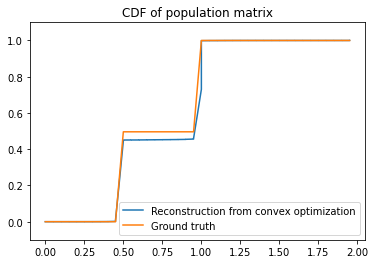

In [13]:
deconvolution('l1','point')
deconvolution('l1','all')

## III. 3. $l^2$ norm

Building cvxpy program...
Solving the convex problem...
Found objective value:  2.0961720087648481e-07


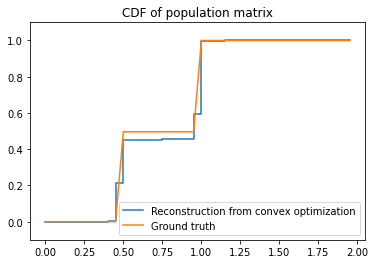

Building cvxpy program...
Solving the convex problem...
0.26853805998682173
Found objective value:  1.7621635133324065e-07


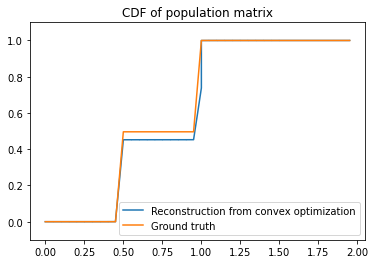

In [14]:
deconvolution('l2','point')
deconvolution('l2','all')